# Preprocessing

## Dataset loading

In [3]:
from datasets import load_dataset

dataset = load_dataset("cifar10")

/home/sharoz/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/home/sharoz/anaconda3/lib/python3.9/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype uint8 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [8]:
from pprint import pprint 

pprint(dataset)

{'test': Dataset({
    features: ['img', 'label'],
    num_rows: 10000
}),
 'train': Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})}


In [17]:
len(dataset['test']['img'])

10000

In [18]:
len(dataset['test']['label'])

10000

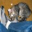

list

In [23]:
display(dataset['test']['img'][0])
type(dataset['test']['label'])

# CNN

In [26]:
!pip install torch --upgrade

     |████████████████████████████████| 670.2 MB 2.3 kB/s eta 0:00:01     |████████████████████▍           | 426.4 MB 1.8 MB/s eta 0:02:17     |███████████████████████         | 480.5 MB 1.2 MB/s eta 0:02:35
     |████████████████████████████████| 121.6 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 209.8 MB 1.4 kB/s eta 0:00:01    |█████████████                   | 85.6 MB 1.1 MB/s eta 0:01:52
     |████████████████████████████████| 823 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 124.2 MB 13 kB/s  eta 0:00:01    |███████████████████             | 73.6 MB 612 kB/s eta 0:01:23     |█████████████████████████████▏  | 113.0 MB 2.3 MB/s eta 0:00:05
     |████████████████████████████████| 23.7 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 56.5 MB 37 kB/s  eta 0:00:01     |█████████                       | 15.9 MB 994 kB/s eta 0:00:41     |███████████████████████████████▍| 55.3 MB 868 kB/s eta 0:00:02
     |███████████████████████████████

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

class CNNClassifier:
    def __init__(self, input_channels, num_classes, conv1_out_channels, conv2_out_channels, fc1_out_features, fc2_out_features, learning_rate, batch_size, num_epochs):
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.conv1_out_channels = conv1_out_channels
        self.conv2_out_channels = conv2_out_channels
        self.fc1_out_features = fc1_out_features
        self.fc2_out_features = fc2_out_features
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs

        # Define the CNN architecture
        self.model = self.build_model()
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def build_model(self):
        model = nn.Sequential(
            nn.Conv2d(self.input_channels, self.conv1_out_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(self.conv1_out_channels, self.conv2_out_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(self.conv2_out_channels * 6 * 6, self.fc1_out_features),
            nn.ReLU(),
            nn.Linear(self.fc1_out_features, self.fc2_out_features),
            nn.ReLU(),
            nn.Linear(self.fc2_out_features, self.num_classes)
        )
        return model

    def train(self, train_loader, val_loader):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for images, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total

            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = self.model(images)
                    loss = self.loss_fn(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * correct / total

            print(f"Epoch {epoch + 1}/{self.num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total

        return accuracy, all_predictions, all_labels


AttributeError: module 'torch' has no attribute 'Tensor'

In [29]:
!pip install torchvision

     |████████████████████████████████| 6.9 MB 276 kB/s eta 0:00:01


In [30]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

class CIFARDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.ToTensor()

    def __len__(self):
       return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(np.array(self.data['img'][idx])) # convert to PIL image
        img_t = self.transform(img) # apply transform
        label = self.data['label'][idx]
        return img_t, label

train_dataset = CIFARDataset(dataset['train'])
test_dataset = CIFARDataset(dataset['test'])

batch_size = 50

#initialize the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

AttributeError: module 'torch' has no attribute '_running_with_deploy'